<a href="https://colab.research.google.com/github/Vakhranev/Compling/blob/master/Vakhranev_AY_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/Week%203/data.py

import math
import numpy as np

from tqdm import tqdm

import torch

import zipfile

import seaborn as sns

from data import Downloader, Parser

--2020-12-27 20:42:07--  https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/Week%203/data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10563 (10K) [text/plain]
Saving to: ‘data.py’

data.py             100%[===================>]  10.32K  --.-KB/s    in 0s      

2020-12-27 20:42:08 (106 MB/s) - ‘data.py’ saved [10563/10563]



### Загружаем файл с эмбеддингами для английского языка
Они нам понадобятся чуть позже.  
Для других языков можете найти здесь: https://fasttext.cc/docs/en/crawl-vectors.html

In [2]:
# раскомментируйте и скачайте
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2020-12-27 20:42:11--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  27.0MB/s    in 25s     

2020-12-27 20:42:37 (26.3 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [3]:
# путь к данным
data_path = './data/'

### Читалка данные
Не стоит вдаваться в подробности, просто эта штука скачивает данные, затем парсит и делает из них три датасета:
- тренировочный
- валидационный
- неразмеченный

Неразмеченные данные необазятельны, но могут вам понадобиться, например, для языковой модели или улучшения эмбеддингов.

In [4]:
downloader = Downloader(data_path=data_path)

In [5]:
downloader.run()

multiple: 100%|██████████| 17/17 [00:18<00:00,  1.08s/it]


In [6]:
parser = Parser(data_path=data_path)

In [7]:
unlabeled, train, valid = parser.run()

Reading: 100%|██████████| 38/38 [02:34<00:00,  4.07s/it]


### Посмотрим на датасеты

In [8]:
unlabeled

,question,response
0,"has anyone used wagner thermoquiets, how do th...",installed on my 96 acorrd for aprox.10k and th...
1,are these good for nighttime? my son is fully...,"i only used them at night, but for a younger b..."
2,is there a gelatin in it?,the label does not mention the capsule content...
3,does it work on motorcycle tires as well and s...,if the valve steam has the same dimension than...
4,does it fit most standard snowmobiles ? (examp...,i am unable to say for sure if it will fit the...
...,...,...
137275,does this product scan to a pdf? does it scan...,it will scan to pdf or jpg. it does scan from...
137276,how far does the flipper stick out when closed...,"the flipper sticks out 5/16"". i don't own the ..."
137277,hi... does this phone works in 1900 mhz 3g ban...,"dear rixio, sorry but this phone ido not work ..."
137278,i recently purchased a shadow billet grill tha...,i'm not really sure.unless that particular gri...


In [9]:
train

,question,response,category
0,do these retro phones come with internal answe...,this one doesn't..but good quality phone.,office products
1,i am new to owning a cat and inherited this 8 ...,it is your job to clip your cats nails. please...,pet supplies
2,is this a smartphone,yes.thank you,cell phones and accessories
3,does this gate have a manual open and close (o...,yes. you can make it so you don't have to use ...,baby
4,do it sheds alot ?,no not at all but you can only wear it syray,beauty
...,...,...,...
249995,how do you open the container? just recieved o...,"what i got came in a jar as pictured, but with...",pet supplies
249996,can this be used with cases? looking at otterb...,yes the otter box defender will work with this...,cell phones and accessories
249997,how many positions does the seat recline befo...,you pull a lever and place it where you want.,baby
249998,can i use xl catrige for this printer?,yes you can.,office products


In [10]:
valid

,question,response,category
0,can i use this with metro pcs 4g?,i dont recommend this phone. i don't want to t...,cell phones and accessories
1,they come with 2 trucks or one?,this ad is for 1 set of (2) trucks.,sports and outdoors
2,is it compatible with ios 7?,yes it is !,cell phones and accessories
3,are these crossbows 2013 modles? the reason i ...,mine says 385,sports and outdoors
4,will this fit on an a1286 antiglare display ma...,yes it should. the key point is the model (128...,cell phones and accessories
...,...,...,...
49995,how big is the bottle opening? i know it sound...,"yup! i have a pump on mine as well, and it's a...",grocery and gourmet food
49996,why does a search for a cover for a 2008 silve...,i am not sure why the search does not reveal r...,automotive
49997,what is the difference between this holster an...,don't buy it sucks,sports and outdoors
49998,will this scope fit my crosman vigilante co2 p...,"didn't fit mine, your better off going to walm...",sports and outdoors


## Задача
Классифицировать поле question в одну из категорий в поле category.  
Это данные с сервиса Amazon QA, то есть такой сервис, на котором можно задать вопрос и получить ответ от других пользователей.

Идея задачи такая: давайте поможем клиенту определить в какую категорию выложить его вопрос, чтобы быстрее получить максимально релевантный ответ.

### Перевод класса в индекс
Мы сделаем некоторый маппер, который текст класса переводит в конкретный уникальный индекс. Нам это понадобиться, потому что наша 
модель работает не напрямую с классом, а с его индексом.

In [11]:
# проверим, что в трейне и валидации одинаковые категории
set(train.category.unique().tolist()) == set(valid.category.unique().tolist())

True

In [12]:
unique_categories = set(train.category.unique().tolist() + valid.category.unique().tolist())

In [13]:
category2index = {category: index for index, category in enumerate(unique_categories)}

In [14]:
category2index

{'automotive': 7,
 'baby': 1,
 'beauty': 4,
 'cell phones and accessories': 5,
 'grocery and gourmet food': 0,
 'office products': 6,
 'pet supplies': 2,
 'sports and outdoors': 3}

In [15]:
train['target'] = train.category.map(category2index)
valid['target'] = valid.category.map(category2index)

In [16]:
train

,question,response,category,target
0,do these retro phones come with internal answe...,this one doesn't..but good quality phone.,office products,6
1,i am new to owning a cat and inherited this 8 ...,it is your job to clip your cats nails. please...,pet supplies,2
2,is this a smartphone,yes.thank you,cell phones and accessories,5
3,does this gate have a manual open and close (o...,yes. you can make it so you don't have to use ...,baby,1
4,do it sheds alot ?,no not at all but you can only wear it syray,beauty,4
...,...,...,...,...
249995,how do you open the container? just recieved o...,"what i got came in a jar as pictured, but with...",pet supplies,2
249996,can this be used with cases? looking at otterb...,yes the otter box defender will work with this...,cell phones and accessories,5
249997,how many positions does the seat recline befo...,you pull a lever and place it where you want.,baby,1
249998,can i use xl catrige for this printer?,yes you can.,office products,6


### Torch Dataset, DataLoader

Очень важная абстракция для торча.
Мы всегда будем ее использовать, чтобы работать с данными.

Dataset - класс, от которого нужно наследоваться, чтобы написать свой обработчик данных. Внутри него нужно реализовать два метода, 
о которых будет чуть ниже. То есть в данном классе вы описывает как нужно преобразовать ваши данные в торчовый формат. Перевести тексты 
в индексы слов и тд.

DataLoader - класс, который будет за вас семплировать данные батчами. Это итератор, поэтому формат работы с ним примерно такой:
```python
for batch in data_loader:
    ...
```
То есть на каждой итерации отдается по одному батчу данных. Итерирование заканчивается, когда вы пройдете все батчи.

Зачем нужны эти абстракции? Чтобы упростить и унифицировать работу с данными.
Вообще вы можете реализовать что-то свое, но это упрощение данной задачи.

In [17]:
from torch.utils.data import Dataset, DataLoader

In [18]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [19]:
# просто рандомные цифры
some_data_x[:10]

array([[0.08638647, 0.03800717, 0.46663545, 0.21257999],
       [0.39067389, 0.9385148 , 0.60444444, 0.6288957 ],
       [0.51720048, 0.61244477, 0.74715835, 0.77869737],
       [0.01570653, 0.41460045, 0.70228668, 0.45624623],
       [0.3599341 , 0.4332824 , 0.7557122 , 0.46946626],
       [0.15759993, 0.08188013, 0.64019966, 0.26926746],
       [0.44527888, 0.83584888, 0.64462564, 0.69378026],
       [0.50340357, 0.2904353 , 0.56935949, 0.83840229],
       [0.60808616, 0.80979437, 0.50969328, 0.51425608],
       [0.55638892, 0.55397949, 0.54293486, 0.38598163]])

In [20]:
# и классы
some_data_y

array([0, 2, 1, ..., 0, 0, 2])

### Пример надобности
Для обучения модели вам нужно подавать в нее батчи данных. Как бы могли это реализовать, если бы у нас не было Dataset и DataLoader

In [21]:
batch_size = 16

for i_batch in range(math.ceil(some_data_x.shape[0] / batch_size)):
    
    x_batch = some_data_x[i_batch * batch_size:(i_batch + 1) * batch_size]
    y_batch = some_data_y[i_batch * batch_size:(i_batch + 1) * batch_size]
    
    x_batch = torch.tensor(x_batch)
    y_batch = torch.tensor(y_batch)
    
    break

In [22]:
x_batch

tensor([[0.0864, 0.0380, 0.4666, 0.2126],
        [0.3907, 0.9385, 0.6044, 0.6289],
        [0.5172, 0.6124, 0.7472, 0.7787],
        [0.0157, 0.4146, 0.7023, 0.4562],
        [0.3599, 0.4333, 0.7557, 0.4695],
        [0.1576, 0.0819, 0.6402, 0.2693],
        [0.4453, 0.8358, 0.6446, 0.6938],
        [0.5034, 0.2904, 0.5694, 0.8384],
        [0.6081, 0.8098, 0.5097, 0.5143],
        [0.5564, 0.5540, 0.5429, 0.3860],
        [0.4610, 0.9529, 0.3618, 0.1034],
        [0.2463, 0.3541, 0.1161, 0.1363],
        [0.5350, 0.4149, 0.6859, 0.9938],
        [0.8152, 0.3636, 0.8799, 0.9992],
        [0.3972, 0.1933, 0.9574, 0.5197],
        [0.2227, 0.1377, 0.5347, 0.2037]], dtype=torch.float64)

In [23]:
x_batch.shape, y_batch.shape

(torch.Size([16, 4]), torch.Size([16]))

Это достаточно простой пример. Мы смогли справиться сами, но почти всегда обработка данных для подачи ее в модель делается сложнее. 
И некоторые вещи часто нужны более одного раза, например, если мы хотим каждую эпоху шафлить наши данные, чтобы получать разные батчи.
Мы сможем это сделать, но для этого нам придется тащить с собой некоторый код из проекта в проект. К тому же совместная разработка или 
просто чтение чужого кода сильно упрощается, когда вы используете унифицированные форматы.

### Перейдем к Dataset
И обернем наши данные в этот обработчик

In [24]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # нужно обязательно определить эту функцию
        # должна возвращать размер датасета
        # нужен для DataLoader, чтобы семплировать батчи
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # еще нужно определить этот метод
        # то есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [25]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [26]:
some_dataset[5], some_dataset[467]

((array([0.15759993, 0.08188013, 0.64019966, 0.26926746]), 1),
 (array([0.7354074 , 0.85413089, 0.5715419 , 0.48697449]), 0))

### Кажется, что смысла в этом нет, но это самый простой пример

### DataLoader
В него мы можем задать некоторые параметры, например, батч сайз и нужно ли шафлить каждый новый проход по данным эти самые данные, 
чтобы получать разные батчи, то есть по разному компоновать эти батчи

In [27]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [28]:
for x, y in some_loader:
    break
    
x

tensor([[0.0097, 0.8532, 0.4664, 0.5398],
        [0.4653, 0.1156, 0.4672, 0.8099],
        [0.1259, 0.0556, 0.3919, 0.4828],
        [0.8191, 0.5687, 0.5632, 0.4424],
        [0.4727, 0.4465, 0.5692, 0.3014],
        [0.7858, 0.0388, 0.1625, 0.4642],
        [0.2544, 0.3052, 0.7089, 0.1462],
        [0.9101, 0.7934, 0.5823, 0.1311],
        [0.8214, 0.4497, 0.6710, 0.3547],
        [0.6884, 0.1024, 0.7512, 0.8907],
        [0.6264, 0.3024, 0.1026, 0.2298],
        [0.8830, 0.4672, 0.8924, 0.4637],
        [0.3349, 0.6619, 0.3936, 0.5651],
        [0.7602, 0.0088, 0.1508, 0.3991],
        [0.9172, 0.5534, 0.0412, 0.2502],
        [0.0849, 0.2727, 0.7924, 0.6793]], dtype=torch.float64)

In [29]:
x.shape

torch.Size([16, 4])

In [30]:
for x, y in some_loader:
    pass

len(x)

15

In [31]:
# почему 15?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

### Усложним обработчик

In [32]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # нужно обязательно определить эту функцию
        # должна возвращать размер датасета
        # нужен для DataLoader, чтобы семплировать батчи
        
        return len(self.data_x)
    
    @staticmethod
    def pow_features(x, n=2):
        
        return x ** n
    
    @staticmethod
    def log_features(x):
        
        return np.log(x)
    
    def __getitem__(self, idx):
        
        # еще нужно определить этот метод
        # то есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x_p_2 = self.pow_features(x, n=2)
        x_p_3 = self.pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x_log = self.log_features(x)
        
        # сконкатенируем наши фичи
        x = np.concatenate([x, x_p_2, x_p_3, x_log])
        
        y = self.data_y[idx]
        
        return x, y

In [33]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [34]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [35]:
for x, y in toy_loader:
    break

In [36]:
x.shape

torch.Size([128, 16])

In [37]:
# заметим, что мы сразу получаем торчовый формат данных, который получился из автоматического преобразования из numpy
x

tensor([[ 0.0864,  0.0380,  0.4666,  ..., -3.2700, -0.7622, -1.5484],
        [ 0.3907,  0.9385,  0.6044,  ..., -0.0635, -0.5034, -0.4638],
        [ 0.5172,  0.6124,  0.7472,  ..., -0.4903, -0.2915, -0.2501],
        ...,
        [ 0.2988,  0.2075,  0.1120,  ..., -1.5724, -2.1894, -1.6828],
        [ 0.2784,  0.7709,  0.3820,  ..., -0.2602, -0.9623, -1.8131],
        [ 0.4726,  0.5038,  0.7518,  ..., -0.6855, -0.2853, -3.9354]],
       dtype=torch.float64)

In [38]:
y

tensor([0, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 2, 1, 2, 2, 0, 0, 1, 2, 2, 1, 1, 0, 0, 2, 2, 0, 1, 0, 2, 0, 0, 0, 0,
        0, 2, 1, 2, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0, 1, 2, 1, 1, 0, 0, 1, 0, 2,
        0, 1, 0, 2, 2, 2, 2, 0, 0, 2, 0, 1, 0, 1, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2,
        2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 1, 2, 2, 1, 1, 0, 1, 0, 0, 2, 1, 2, 1, 0,
        2, 0, 2, 1, 2, 1, 0, 0])

In [39]:
# сделаем небольшую модель и посчитаем лосс

model = torch.nn.Sequential(torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 4),
                            torch.nn.ReLU(),
                            torch.nn.Linear(4, 3))

criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)
    
loss.item()

1.1485671997070312

### Сделаем датасет для наших текстовых данных
Будем отдавать строку и таргет по индексу

In [40]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        
        text = self.texts[index]
        target = self.targets[index]
        
        return text, target

In [41]:
# подготовим данные
train_x = list(train.question)
train_y = list(train.target)

valid_x = list(valid.question)
valid_y = list(valid.target)

In [42]:
train_dataset = TextClassificationDataset(texts=list(train.question), targets=list(train.target))

In [43]:
# семплируем данные
text, target = train_dataset[0]

In [44]:
text

'do these retro phones come with internal answering service'

In [45]:
target

6

### Смысл обработчика
Состоит в том, что нам нужно преобразовать наши данные в формат, который мы уже сможем передать в модель.
Сейчас у нас строки, а торч ничего не знает про строки, ему нужны тензоры.

### Загружаем эмбеддинги
Чтобы работать с текстовыми данными мы можем разбить наши строки на слова, а слова перевести в вектора. Откуда нам взять эти вектора?
Мы говорили про такой метод как word2vec и в начале этой тетрадки загружали файл с этими самыми векторами.

In [46]:
import zipfile
import numpy as np

from tqdm import tqdm

In [47]:
def load_embeddings(zip_path, filename, pad_token='PAD', max_words=100_000, verbose=True):
    
    vocab = dict()
    embeddings = list()

    with zipfile.ZipFile(zip_path) as zipped_file:
        with zipped_file.open(filename) as file_object:

            vocab_size, embedding_dim = file_object.readline().decode('utf-8').strip().split()

            vocab_size = int(vocab_size)
            embedding_dim = int(embedding_dim)
            
            # в файле 1 000 000 слов с векторами, давайте ограничим для простоты этот словарь
            max_words = vocab_size if max_words <= 0 else max_words
            
            # добавим пад токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
            vocab[pad_token] = len(vocab)
            embeddings.append(np.zeros(embedding_dim))

            progress_bar = tqdm(total=max_words, disable=not verbose)

            for line in file_object:
                parts = line.decode('utf-8').strip().split()

                token = ' '.join(parts[:-embedding_dim]).lower()
                
                if token in vocab:
                    continue
                
                word_vector = np.array(list(map(float, parts[-embedding_dim:])))

                vocab[token] = len(vocab)
                embeddings.append(word_vector)

                progress_bar.update()
                
                if len(vocab) == max_words:
                    break

            progress_bar.close()

    embeddings = np.stack(embeddings)
    
    return vocab, embeddings

In [48]:
vocab, embeddings = load_embeddings('./wiki-news-300d-1M.vec.zip', 'wiki-news-300d-1M.vec', max_words=100_000)

100%|█████████▉| 99999/100000 [00:12<00:00, 7888.61it/s]


### Посмотрим на ближайших соседей слова по эмбеддингам

In [49]:
index2token = {index: token for token, index in vocab.items()}

In [50]:
emb_norms = np.linalg.norm(embeddings, axis=1)

In [51]:
def get_k_nearest_neighbors(word, embeddings, emb_norms, vocab, index2token, k=5):
    
    if word not in vocab:
        print('Not in vocab')
        return
    
    word_index = vocab[word]

    word_vector = embeddings[word_index]
    word_vector = np.expand_dims(word_vector, 0)

    scores = (word_vector @ embeddings.T)[0]
    
    # переводим в косинусы, поделив на нормы векторов
    # эпсилон 1e-6 для того, чтобы не делить на 0
    scores = scores / (emb_norms + 1e-6) / emb_norms[word_index]
    
    # 1:k+1 потому что первый вариант это само слово
    for idx in scores.argsort()[::-1][1:k+1]:
        print(f'Слово {index2token[idx]} близко на {scores[idx]:.2f} к слову {word}')

In [52]:
get_k_nearest_neighbors('anna', embeddings, emb_norms, vocab, index2token)

Слово maria близко на 0.73 к слову anna
Слово emma близко на 0.66 к слову anna
Слово kristina близко на 0.65 к слову anna
Слово laura близко на 0.65 к слову anna
Слово emily близко на 0.65 к слову anna


In [53]:
get_k_nearest_neighbors('mom', embeddings, emb_norms, vocab, index2token)

Слово dad близко на 0.85 к слову mom
Слово mum близко на 0.78 к слову mom
Слово mother близко на 0.76 к слову mom
Слово moms близко на 0.75 к слову mom
Слово kid близко на 0.68 к слову mom


In [54]:
get_k_nearest_neighbors('have', embeddings, emb_norms, vocab, index2token)

Слово has близко на 0.78 к слову have
Слово been близко на 0.75 к слову have
Слово 've близко на 0.75 к слову have
Слово had близко на 0.74 к слову have
Слово ahve близко на 0.74 к слову have


In [55]:
get_k_nearest_neighbors('money', embeddings, emb_norms, vocab, index2token)

Слово cash близко на 0.72 к слову money
Слово funds близко на 0.72 к слову money
Слово monies близко на 0.72 к слову money
Слово moneys близко на 0.67 к слову money
Слово dosh близко на 0.63 к слову money


In [56]:
get_k_nearest_neighbors('music', embeddings, emb_norms, vocab, index2token)

Слово musical близко на 0.71 к слову music
Слово songs близко на 0.69 к слову music
Слово tunes близко на 0.69 к слову music
Слово musics близко на 0.68 к слову music
Слово composer близко на 0.68 к слову music


### Выбор метода токенизации
У нас сейчас есть маппинг, что некоторому слову соответствует некоторый эмбеддинг этого слова.
Токенизация - процесс разбиения текста на токены, то есть части этого текста.   
Чем "слово" отличается от "токена": токен это более обобщенное понятие, то есть, например, цифра это токен

In [57]:
# про различия подробнее можно найти, например, здесь
# https://stackoverflow.com/questions/50240029/nltk-wordpunct-tokenize-vs-word-tokenize
from nltk.tokenize import word_tokenize, wordpunct_tokenize

In [58]:
total_n_words = 0
unknown_words = list()

for sample in tqdm(train_x):
    # токенизация по пробелу
    tokens = sample.split()
    
    for tok in tokens:
        # проверяем есть ли токен в нашем словаре
        if tok not in vocab:
            unknown_words.append(tok)
            
        total_n_words += 1
        
print(f'Мы не знаем {len(unknown_words)} слов из {total_n_words} слов в датасете')
print(f'Что составляет {len(unknown_words) * 100 / total_n_words:.2f}% датасета')
print()
print(f'Уникальных неизвестных слов: {len(set(unknown_words))}')

100%|██████████| 250000/250000 [00:01<00:00, 177105.69it/s]

Мы не знаем 512180 слов из 3606201 слов в датасете
Что составляет 14.20% датасета

Уникальных неизвестных слов: 119197


In [59]:
total_n_words = 0
unknown_words = list()

for sample in tqdm(train_x):
    # токенизация
    tokens = wordpunct_tokenize(sample)
    
    for tok in tokens:
        # проверяем есть ли токен в нашем словаре
        if tok not in vocab:
            unknown_words.append(tok)
            
        total_n_words += 1
        
print(f'Мы не знаем {len(unknown_words)} слов из {total_n_words} слов в датасете')
print(f'Что составляет {len(unknown_words) * 100 / total_n_words:.2f}% датасета')
print()
print(f'Уникальных неизвестных слов: {len(set(unknown_words))}')

100%|██████████| 250000/250000 [00:02<00:00, 102724.93it/s]

Мы не знаем 111115 слов из 4202739 слов в датасете
Что составляет 2.64% датасета

Уникальных неизвестных слов: 36270


In [60]:
import nltk
nltk.download('punkt')

total_n_words = 0
unknown_words = list()

for sample in tqdm(train_x):
    # токенизация
    tokens = word_tokenize(sample)
    
    for tok in tokens:
        # проверяем есть ли токен в нашем словаре
        if tok not in vocab:
            unknown_words.append(tok)
            
        total_n_words += 1
        
print(f'Мы не знаем {len(unknown_words)} слов из {total_n_words} слов в датасете')
print(f'Что составляет {len(unknown_words) * 100 / total_n_words:.2f}% датасета')
print()
print(f'Уникальных неизвестных слов: {len(set(unknown_words))}')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


100%|██████████| 250000/250000 [00:46<00:00, 5383.83it/s]

Мы не знаем 151779 слов из 4103252 слов в датасете
Что составляет 3.70% датасета

Уникальных неизвестных слов: 54139


### Результаты
- Скорость у word_tokenize сильно ниже, чем у wordpunct_tokenize
- Используя word_tokenize, мы теряем примерно 1% информации из датасета по сравнению с wordpunct_tokenize

### Выбор очевиден в сторону wordpunct_tokenize

In [61]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets, vocab):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        
    def __len__(self):
        return len(self.texts)
    
    def tokenization(self, text):
        
        tokens = wordpunct_tokenize(text)
        
        token_indices = [self.vocab[tok] for tok in tokens if tok in self.vocab]
        
        return token_indices
    
    def __getitem__(self, index):
        
        text = self.texts[index]        
        target = self.targets[index]
        
        tokenized_text = self.tokenization(text)
        
        # переведем наши индексы токенов в торчовый тензор
        # таргет переведется самостоятельно
        tokenized_text = torch.tensor(tokenized_text)
        
        return tokenized_text, target

In [62]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)

In [63]:
x, y = train_dataset[5]

In [64]:
x

tensor([  128,   122, 88992,   471,     7,     2,  2354,    37])

In [65]:
y

1

In [66]:
# мы можем восстановить текст обратно по индексам слов
[index2token[idx.item()] for idx in x]

['how', 'many', 'diaphragms', 'come', 'in', 'the', 'package', '?']

### У нас остается проблема разных длин текстов
Чтобы поместить батч текстов в один тензор нам нужны одинаковые длины

In [67]:
## это не отработает, можете раскомментировать и проверить

# x = [
#     [1, 2, 3],
#     [1, 2, 3, 4, 5],
#     [1, 2, 3, 4, 5, 6, 7]
# ]

# torch.tensor(x), torch.tensor(x).shape

In [68]:
# это сработает

x = [
    [1, 2, 3, 0, 0, 0, 0],
    [1, 2, 3, 4, 5, 0, 0],
    [1, 2, 3, 4, 5, 6, 7]
]

torch.tensor(x), torch.tensor(x).shape

(tensor([[1, 2, 3, 0, 0, 0, 0],
         [1, 2, 3, 4, 5, 0, 0],
         [1, 2, 3, 4, 5, 6, 7]]), torch.Size([3, 7]))

### Длина текста
Нам нужно понять до какой длины нам падить каждый наш пример. 
Мы можем найти в наших данных максимальную длину примера в токенах и падить до этой длины, но у этого подхода есть минус:
у нас могут быть несколько текстов с аномально большой длиной, то есть некоторые выбросы.  

В таком случае нам легче ограничить длину этих текстов до определенной статистики по нашему датасет, то есть, например, 95% наших текстов
длиной в 25 слов и нам этого достаточно. То есть мы ограничимся этой длиной, потому что почти весь датасет влезает в эту длину
и нам не нужно будет падить до большой длины.

Паддинг нужен нам для того, чтобы мы могли поместить разные примеры в один батч, но мы не хотим учитывать эти токены, то есть 
по сути это будут холостые прогоны и за счет этого компромисса, что бОльшая часть датасета не больше n слов мы можем оптимизировать 
наше обучение.

<br>


> Почему бы нам просто не выкинуть эти длинные тексты?

Дело в том, что мы хотим прийти к некоторому компромиссу между максимальной длиной и потерей информации. Если мы возьмем 95-й перцинтиль наших длин (то есть 95% наших текстов не больше n), то, выкинув остальные 5%, мы потеряем существенную часть примеров.
С другой стороны может показаться неправильным ограничение длины и это действительно может сломать смысл примеры, но зачастую этим 
принебрегают.

In [69]:
train_lengths = [len(wordpunct_tokenize(sample)) for sample in tqdm(train_x)]

100%|██████████| 250000/250000 [00:01<00:00, 192368.10it/s]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


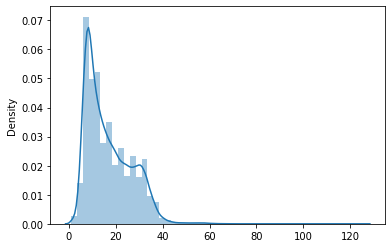

In [70]:
sns.distplot(train_lengths)

In [71]:
# видим большие выбросы в данных
# 97% наших текстов не больше вот стольки токенов
np.percentile(train_lengths, 95)

34.0

In [72]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets, vocab, pad_index=0, max_length=32):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        
        self.pad_index = pad_index
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def tokenization(self, text):
        
        tokens = wordpunct_tokenize(text)
        
        token_indices = [self.vocab[tok] for tok in tokens if tok in self.vocab]
        
        return token_indices
    
    def padding(self, tokenized_text):
        
        tokenized_text = tokenized_text[:self.max_length]
        
        tokenized_text += [self.pad_index] * (self.max_length - len(tokenized_text))
        
        return tokenized_text
    
    def __getitem__(self, index):
        
        text = self.texts[index]        
        target = self.targets[index]
        
        tokenized_text = self.tokenization(text)
        tokenized_text = self.padding(tokenized_text)
        
        tokenized_text = torch.tensor(tokenized_text)
        
        return tokenized_text, target

In [73]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)

In [74]:
x, y = train_dataset[0]
x

tensor([   97,   130, 19818,  4944,   471,    18,  2194,  7198,   303,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [75]:
[index2token[idx.item()] for idx in x]

['do',
 'these',
 'retro',
 'phones',
 'come',
 'with',
 'internal',
 'answering',
 'service',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

In [76]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)
valid_dataset = TextClassificationDataset(texts=valid_x, targets=valid_y, vocab=vocab)

train_loader = DataLoader(train_dataset, batch_size=128)
valid_loader = DataLoader(valid_dataset, batch_size=128)

In [77]:
for x, y in train_loader:
    break

In [78]:
x.shape, y.shape

(torch.Size([128, 32]), torch.Size([128]))

### Как мы можем задавать слои

In [79]:
from torch import nn

In [80]:
embedding_layer = nn.Embedding(num_embeddings=len(vocab), 
                               embedding_dim=embeddings.shape[-1],
                               padding_idx=0)

In [81]:
x_embed = embedding_layer(x)

In [82]:
x_embed

tensor([[[-1.5032,  0.5244, -0.0188,  ..., -0.0563,  1.3449,  0.2796],
         [-0.4550,  0.7821, -2.3234,  ...,  1.2823, -0.8049, -0.3680],
         [-0.7654,  1.1716,  0.2131,  ..., -0.4465, -0.4284, -1.2080],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.1407,  1.6161,  0.1731,  ..., -2.0524, -1.3058, -0.4026],
         [-0.3832,  0.0110, -0.5930,  ...,  0.1208,  0.7506, -0.5068],
         [ 0.8138,  0.7669,  0.2090,  ...,  1.0196,  0.5303, -0.7073],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.1672, -1.2065,  0.0213,  ..., -0.8832,  0.3029, -0.2014],
         [ 0.2399, -0.1744,  0.3792,  ...,  0

In [83]:
x_embed.shape

torch.Size([128, 32, 300])

### Но мы ведь прочитали нашу матрицу эмбеддингов
Таким образом она инициализируется предобученными весами.  
При такой инициализации по умолчанию она замораживается, внутри ```.from_pretrained(embeddings, padding_idx=0)``` есть флаг ```freeze```, который отвечает за необходимость заморозки весов. То есть эти веса в процессе обучения не будут обновляться.

In [84]:
embeddings = torch.tensor(embeddings).float()

In [85]:
embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)

In [86]:
x_embed = embedding_layer(x)

### Немного LSTM
Ниже будет про ```batch_first=True```

In [87]:
lstm = nn.LSTM(input_size=300, hidden_size=128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)

In [88]:
x_lstm, _ = lstm(x_embed)

In [89]:
# 256 потому что это конкатенация лстмки, которая прочитала текст слева направо
# и лстмки, которая прочитала текст справа налево
x_lstm.shape

torch.Size([128, 32, 256])

In [90]:
# избавились от временной размерности
x_lstm.mean(dim=1).shape

torch.Size([128, 256])

### Сделаем свою сеть
В первой домашке в конце есть более подробная информация почему мы используем классы.

In [91]:
class DeepAverageNetwork(nn.Module):
    
    def __init__(self, embeddings, linear_1_size, linear_2_size, n_classes):
        super().__init__()
        
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)
        
        self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
        
        self.linear_1 = nn.Linear(in_features=embeddings.shape[-1], out_features=linear_1_size)
        self.linear_2 = nn.Linear(in_features=linear_1_size, out_features=linear_2_size)
        self.linear_3 = nn.Linear(in_features=linear_2_size, out_features=n_classes)
        
    def forward(self, x):
        
        # переводим индексы слов в эмбеддинги этих слов
        # (batch_size, sequence_length) -> (batch_size, sequence_length, embedding_dim)
        x = self.embedding_layer(x)
        
        # агрегируем наши эмбеддинги по размерности время
        # (batch_size, sequence_length, embedding_dim) -> (batch_size, embedding_dim)
        x = x.sum(dim=1)
        
        # делаем нормирование
        # (batch_size, embedding_dim) -> (batch_size, embedding_dim)
        x = self.batch_norm(x)
        
        # прогоняем через первый линейный слой
        # (batch_size, embedding_dim) -> (batch_size, linear_1_size)
        x = self.linear_1(x)
        
        # применяем нелинейность
        # (batch_size, linear_1_size) -> (batch_size, linear_1_size)
        x = torch.relu(x)
        
        # прогоняем через второй линейный слой
        # (batch_size, linear_1_size) -> (batch_size, linear_2_size)
        x = self.linear_2(x)
        
        # применяем нелинейность
        # (batch_size, linear_2_size) -> (batch_size, linear_2_size)
        x = torch.relu(x)
        
        # переводим с помощью линейного преобразования в количество классов
        # (batch_size, linear_2_size) -> (batch_size, n_classes)
        x = self.linear_3(x)
        
        ## по идеи здесь должен был быть софтмакс
        ## но мы будем использовать лосс nn.CrossEntropyLoss()
        ## в его документации написано
        ## This criterion combines :func:`nn.LogSoftmax` and :func:`nn.NLLLoss` in one single class.
        ## это некоторая оптимизация, которая включает в себя сразу и софтмакс и сам negative log likelihood лосс
        ## так как у нас в лоссе есть софтмакс, то мы не будем применять его в сетке
        ## на этапе предсказания (а не обучения) мы будем отдельно делать софтмакс для получения распределения классов
        ## 
        ## (batch_size, n_classes) -> (batch_size, n_classes)
        # x = torch.softmax(x, dim=-1)
        
        return x

In [92]:
model = DeepAverageNetwork(embeddings=embeddings,
                           linear_1_size=256, 
                           linear_2_size=128, 
                           n_classes=len(category2index))

In [93]:
criterion = nn.CrossEntropyLoss()

# задайте оптимизатор
optimizer = torch.optim.Adam(params=model.parameters())

### Напишите цикл обучения
Что он должен в себя включать:
1. Получение предсказаний модели
1. Расчет функции потерь
1. Расчет градиентов
1. Шаг градиентного спуска
1. Обнуление градиентов
1. Записывание значения лосса

In [94]:
losses = list()

# в обучении моделей у нас есть такая ситуация, что некоторые слои ведут себя по разному на этапе тренировки и предсказания
# например, батч норм (а так же все остальные нормировки) и дропаут
# это переводит модель в режим тренировки
model.train()
for x, y in train_loader:
  prediction = model.forward(x)
  loss = criterion(prediction, y)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  losses.append(loss)
print(f"Train loss: {loss}")

Train loss: 1.647088646888733


In [95]:
print(losses)

[tensor(2.0773, grad_fn=<NllLossBackward>), tensor(2.0346, grad_fn=<NllLossBackward>), tensor(2.0108, grad_fn=<NllLossBackward>), tensor(2.0097, grad_fn=<NllLossBackward>), tensor(1.9603, grad_fn=<NllLossBackward>), tensor(1.8956, grad_fn=<NllLossBackward>), tensor(1.9280, grad_fn=<NllLossBackward>), tensor(1.8975, grad_fn=<NllLossBackward>), tensor(1.8810, grad_fn=<NllLossBackward>), tensor(1.9160, grad_fn=<NllLossBackward>), tensor(1.8440, grad_fn=<NllLossBackward>), tensor(1.9020, grad_fn=<NllLossBackward>), tensor(1.8204, grad_fn=<NllLossBackward>), tensor(1.8374, grad_fn=<NllLossBackward>), tensor(1.6289, grad_fn=<NllLossBackward>), tensor(1.8457, grad_fn=<NllLossBackward>), tensor(1.8093, grad_fn=<NllLossBackward>), tensor(1.6804, grad_fn=<NllLossBackward>), tensor(1.6072, grad_fn=<NllLossBackward>), tensor(1.5779, grad_fn=<NllLossBackward>), tensor(1.5963, grad_fn=<NllLossBackward>), tensor(1.5446, grad_fn=<NllLossBackward>), tensor(1.4888, grad_fn=<NllLossBackward>), tensor(1.5

### Напишите цикл валидации
Что он должен в себя включать:
1. Получение предсказаний модели
1. Расчет функции потерь
1. Записывание значения лосса

Также с помощью контекста ```with torch.no_grad():``` можно явно указать торчу не сохранять необходимые параметры для расчета градиентов. Обязательно для режима предсказания.

In [96]:
losses = list()

# это переводит модель в режим предсказания
# то есть фиксируются статистики батч норма, дропаут не выкидывает фичи
model.eval()

# заметьте, что мы поменяли наш лоадер на валидационный
for x, y in valid_loader:
    
    with torch.no_grad():
        # получение предсказаний модели
        # расчет лосса
        prediction = model.forward(x)
        loss = criterion(prediction, y)
        losses.append(loss)
print(f"Validation loss: {loss}")

Validation loss: 0.9907236099243164


In [97]:
print(losses)

[tensor(1.0799), tensor(1.0703), tensor(0.9349), tensor(1.0394), tensor(1.0949), tensor(0.9599), tensor(0.9383), tensor(1.0513), tensor(0.9506), tensor(0.9359), tensor(0.9180), tensor(0.9161), tensor(0.8734), tensor(0.8830), tensor(0.8905), tensor(0.9049), tensor(1.0106), tensor(1.0366), tensor(0.9936), tensor(1.0242), tensor(1.0650), tensor(1.1092), tensor(0.8566), tensor(0.8838), tensor(0.9048), tensor(0.9269), tensor(1.1119), tensor(1.0157), tensor(1.0317), tensor(0.8431), tensor(0.8540), tensor(1.0820), tensor(0.8866), tensor(0.8910), tensor(0.9537), tensor(0.9437), tensor(0.9196), tensor(0.9435), tensor(1.0024), tensor(0.9045), tensor(1.0789), tensor(1.0695), tensor(0.8790), tensor(1.0785), tensor(0.9241), tensor(0.8743), tensor(0.8208), tensor(1.1565), tensor(0.8539), tensor(1.1250), tensor(1.0391), tensor(0.8069), tensor(0.9178), tensor(0.7759), tensor(0.8628), tensor(1.0841), tensor(0.8747), tensor(1.2374), tensor(0.8999), tensor(0.8385), tensor(0.8091), tensor(0.8818), tensor(

### Проведите обучение несколько эпох
Одна эпоха - это один проход по датасету.  
Шаги:
- Поменяйте что-нибудь в модели, добавить дропаут и тд
- Остановите обучение с помощью early stopping
- Добавьте расчет метрик во время обучения и предсказания (например, micro F1). Чтобы это сделать вы можете, например, сохранять предсказания модели
- После обучения нарисуйте как по мере обучения меняется функция потерь на тренировочном и валидационном датасете, как меняется метрики
- Опционально: постройте confusion matrix

Подсказки:
- Чтобы корректно сохранять предсказания нужно переменную отсоединить от графа, то есть сделать ```x.detach()```

In [98]:
class DeepAverageNetwork(nn.Module):
    
    def __init__(self, embeddings, linear_1_size, linear_2_size, n_classes, loss):
        super().__init__()
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)
        self.dropout = nn.Dropout(p=0.1)
        self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
        self.linear_1 = nn.Linear(in_features=embeddings.shape[-1], out_features=linear_1_size)
        self.linear_2 = nn.Linear(in_features=linear_1_size, out_features=linear_2_size)
        self.linear_3 = nn.Linear(in_features=linear_2_size, out_features=n_classes)
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x = x.sum(dim=1)
        x = self.batch_norm(x)
        x = self.linear_1(x)
        x = torch.relu(x)
        x = self.linear_2(x)
        x = torch.relu(x)
        x = self.linear_3(x)
        return x

In [99]:
from sklearn.metrics import f1_score
for instance in list(tqdm._instances):
  tqdm._decr_instances(instance)
best_val_loss = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)
losses = list()
epochs = 6
for epoch in range(epochs):
  train_losses = []
  valid_losses = []
  valid_targets = list()
  valid_predictions = list()
  model.train()
  for x, y in train_loader:
    prediction = model.forward(x)
    loss = criterion(prediction, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_losses.append(loss.item())
    losses.append(loss.item())
    for instance in list(tqdm._instances):
      tqdm._decr_instances(instance)
  scheduler.step()
  model.eval()
  for x, y in valid_loader:
    with torch.no_grad():
      prediction = model.forward(x)
      y_pred = torch.softmax(prediction, dim=-1)
      optimizer.zero_grad()
      val_loss = criterion(y_pred, y)
      optimizer.step()
      optimizer.zero_grad()
      optimizer.step()
  valid_targets.append(y.numpy())
  valid_predictions.append(prediction.numpy())
  loss = criterion(prediction, y.squeeze())
  valid_losses.append(loss.item())
  for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)
  mean_val_loss = np.mean(valid_losses)
  #if mean_val_loss < best_val_loss:
  #    best_val_loss = mean_val_loss
  #else:
  #    break
  print(f"epoch {epoch} validation loss {val_loss}, train loss {loss}")

epoch 0 validation loss 1.6621997356414795, train loss 0.9419354200363159
epoch 1 validation loss 1.6574821472167969, train loss 0.935039222240448
epoch 2 validation loss 1.6534706354141235, train loss 0.9328190684318542
epoch 3 validation loss 1.6500110626220703, train loss 0.9318434596061707
epoch 4 validation loss 1.6470098495483398, train loss 0.9285534024238586
epoch 5 validation loss 1.6445133686065674, train loss 0.9274650812149048


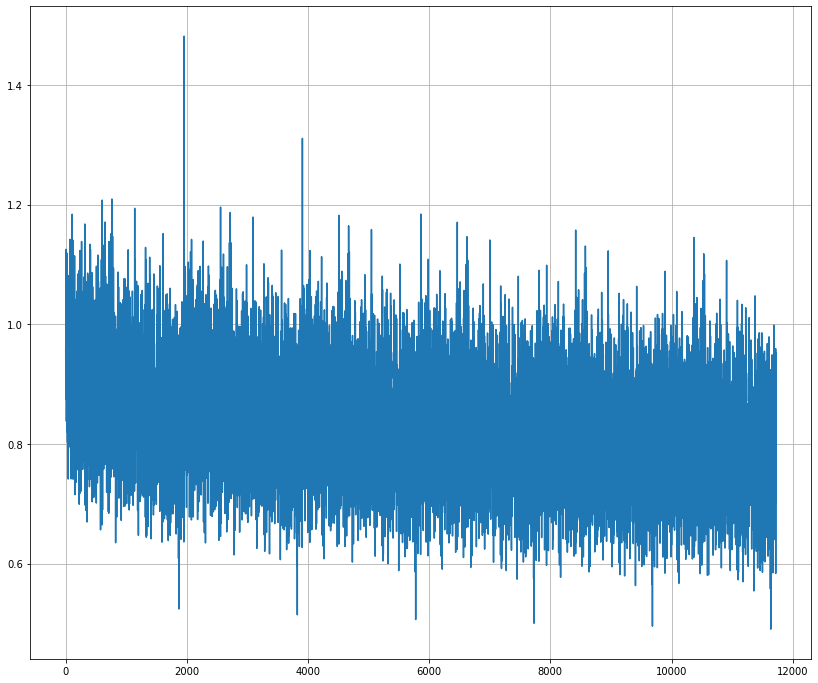

In [100]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()

### Важные и не очень интуитивные моменты про LSTM и CNN в торче

По умолчанию LSTM принимает данные с такой размерностью:
```python
(seq_len, batch, input_size)
```
Сделано это с целью оптимизации на более низком уровне.  
Мы оперируем такими объектами:
```python
(batch, seq_len, input_size)
```
Чтобы LSTM у нас заработала правильно, мы можем либо передать параметр ```batch_first=True``` во время инициализации слоя,
либо транспонировать (поменять) первую и вторую размерность у нашего x перед подачей в слой.  
[Подробнее про LSTM](https://pytorch.org/docs/stable/nn.html#lstm)

- 128 - размер батча
- 64 - длина последовательности (количество слов)
- 1024 - эмбеддинг слова

In [101]:
x = torch.rand(128, 64, 1024)

In [102]:
# первый способ
lstm = torch.nn.LSTM(1024, 512, batch_first=True)

pred, mem = lstm(x)

In [103]:
pred.shape

torch.Size([128, 64, 512])

In [104]:
# второй способ
lstm = torch.nn.LSTM(1024, 512)

# меняем размерность batch и seq_len местами
x_transposed = x.transpose(0, 1)
pred_transposed, mem = lstm(x_transposed)

In [105]:
# у нас все еще осталась размерность (seq_len, batch, input_size)
pred_transposed.shape

torch.Size([64, 128, 512])

In [106]:
# просто транспонируем еще раз
pred = pred_transposed.transpose(0, 1)
pred.shape

torch.Size([128, 64, 512])

### Conv1d & MaxPool1d
Примерно такая же ситуация происходит со сверточными слоями и пулингами.  
1d реализация как раз для текстов, в ней матрица-фильтр ходит только по одной размерности.  
[Подробнее про CNN](https://pytorch.org/docs/stable/nn.html#conv1d)  
[Подробнее про пулинг](https://pytorch.org/docs/stable/nn.html#maxpool1d)  
Ожидается такая размерность:
```python
(batch, input_size, seq_len)
```
Мы все еще хоти подавать такую размерность:
```python
(batch, seq_len, input_size)
```
В случае со свертками и пулингами у нас есть вариант только транспонировать x перед подачей и транспонировать полученный результат. Обратите внимание, что транспонируем мы первую и вторую размерность (индексация с нуля).

In [107]:
x.shape

torch.Size([128, 64, 1024])

In [108]:
# in_channels - размер входных эмбеддингов
# out_channels - количество/какой размер эмбеддингов мы хотим получить
# kernel_size - размер окна/н-граммы
cnn = torch.nn.Conv1d(in_channels=1024, out_channels=512, kernel_size=3)

In [109]:
# выпадет ошибка, посмотрите какая
# pred = cnn(x)

In [110]:
x_transposed = x.transpose(1, 2)
x_transposed.shape
# перевели в (batch, input_size, seq_len)

torch.Size([128, 1024, 64])

In [111]:
pred_transposed = cnn(x_transposed)
pred_transposed.shape
# осталась разрмерность (batch, output_size, seq_len)

torch.Size([128, 512, 62])

In [112]:
# переведем обратно в (batch, seq_len, input_size)
pred = pred_transposed.transpose(1, 2)
pred.shape

torch.Size([128, 62, 512])

### Еще важный момент про LSTM

The input can also be a packed variable length sequence. See [torch.nn.utils.rnn.pack_padded_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence) or [torch.nn.utils.rnn.pack_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_sequence) for details.

Это внутренняя конструкция торча, которая позволяет не читать токен ```PAD```, но все еще работать с батчами. То есть внутри батча мы можем передать лстмке, что у нас данные переменной длины. Не забудьте что на выход отдается [torch.nn.utils.rnn.PackedSequence](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.PackedSequence).

## Домашнее задание

1. Сделать класс нейронки, вписать необходимые операции, архитектура ниже
1. Написать обучалку (обобщить то, что было выше)
1. Добавить логирование
    1. Сохранять лосс на каждой итерции обучения __0.25 балла__
    1. Каждую эпоху сохранять лосс трейна и тест __0.25 балла__
    1. Каждую эпоху рассчитывать метрики __0.25 балла__
    1. Добавить прогресс бар, в котором показывается усредненный лосс последних 500-та итераций __0.25 балла__
1. Добавить early stopping __0.5 балла__
1. Нарисовать графики лосса, метрик, конфьюжин матрицу __0.5 балла__


### Архитектура (что можно попробовать)
1. Предобученные эмбеддинги. Почитайте [здесь](https://pytorch.org/docs/stable/nn.html#embedding) (from_pretrained) как вставить свои эмбеддинги, выше мы читали матрицу эмбеддингов. __0 баллов__
1. Дообучить эмбеддинги отдельно от сети. __2 балла__
1. Дообучить эмбеддинги вместе с сетью и с другим learning rate (указывается в оптимизаторе). __2 балла__
1. Bidirectional LSTM. __1 балл__
1. Несколько параллельных CNN с разными размерами окна и mean/max over time пулингами к ним и дальнейшей конкатенацией. __2 балла__
1. Несколько последовательных CNN. __1 балла__
1. Разные окна и residual к предыдущему пункту. __2 балла__
1. Предыдущий пункт сделан без ошибок (замаскированы свертки паддингов). __2 балла__
1. Написать правильный правильный mean/max пулинг, который не учитывает паддинги, точнее их маскирует. __2 балла__
1. Добавить [torch.nn.utils.rnn.pack_padded_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence) и [torch.nn.utils.rnn.pack_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_sequence) для LSTM. Инфа [здесь](#Еще-важный-момент-про-LSTM) __2 балла__
1. Добавить spatial дропаут для входа LSTM (не просто стандартный пункт при инициализации LSTM) __1 балл__
1. Добавить BatchNorm/LayerNorm/Dropout/Residual/etc __1 балл__
1. Добавить шедуллер __1 балл__
1. Обучать на GPU __2 балла__
1. Сделать transfer learning с собственно обученной языковой модели, обученной на любых данных, например, unlabeled. __7 баллов__
1. your madness

## 10 баллов максимум

# По итогам напишите результаты экспериментов
# Что получилось, а что нет
# Почему, выводы

Параллельные CNN

In [113]:
class Paral_CNN(nn.Module):
    
    def __init__(self, embeddings, linear_1_size, linear_2_size, n_classes):
        super().__init__()
        
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)
        
        self.input_size = embeddings.shape[-1]
        self.conv_size = int(self.input_size/2)
        self.padding = nn.ConstantPad1d(padding=1, value=float('-inf'))

        self.conv1 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=2, stride=1, padding=1)

        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

        self.linear_1 = nn.Linear(in_features=101, out_features=32)
        self.linear_2 = nn.Linear(in_features=linear_1_size, out_features=linear_2_size)
        self.linear_3 = nn.Linear(in_features=linear_2_size, out_features=n_classes)
        
    def forward(self, x):
        
        x = self.embedding_layer(x)

        x1 = self.conv1(x)
        x1 = torch.max_pool1d(x1,padding=1, kernel_size=3)

        x2 = self.conv2(x)
        x2 = torch.avg_pool1d(x2, padding=1, kernel_size=3)

        x = torch.cat([x1, x2], dim=1)
        x = self.relu(x)
        x = self.linear_1(x)
        x = x.sum(dim=1)
        x = torch.relu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        x = torch.relu(x)
        x = self.linear_3(x)
        
        
        return x

In [114]:
model = Paral_CNN(embeddings=embeddings, linear_1_size = 32, linear_2_size = 16, n_classes=len(category2index))

In [115]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1)

In [ ]:
epochs = 6
train_losses = []
test_losses = []
for epoch in range(epochs):
  for x, y in train_loader:
    #print(y)
    y_pred = model.forward(x)
    #print(y_pred)
    train_loss = criterion(y_pred, y)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
  train_losses.append(train_loss)
  scheduler.step()
  for x, y in valid_loader:        
      with torch.no_grad():
          x_forw = model.forward(x)
          y_pred = torch.softmax(x_forw, dim=-1)
          optimizer.zero_grad()
          test_loss = criterion(y_pred, y)
          acc_list.append(test_acc)
          optimizer.step()
          optimizer.zero_grad()
          optimizer.step()
  test_losses.append(test_loss)
  print(f"epoch {epoch} train loss {train_loss}, test loss {test_loss}")

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(range(epochs), train_losses)
plt.grid()

Последовательные CNN

In [ ]:
class Posl_CNN(nn.Module):
    
    def __init__(self, embeddings, linear_1_size, linear_2_size, n_classes):
        super().__init__()
        
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0, freeze=False)

        self.input_size = embeddings.shape[-1]
        self.conv_size_1 = int(self.input_size/2)
        self.conv_size_2 = int(self.conv_size_1/2)

        self.conv1 = nn.Conv1d(in_channels=self.input_size, out_channels=self.conv_size_1, kernel_size=3, stride=1, padding=0)
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv1d(in_channels=self.conv_size_1, out_channels=self.conv_size_2, kernel_size=3, stride=1, padding=0)
        self.pool2 = nn.MaxPool1d(kernel_size=3, stride=1, padding=0)

        self.batch_norm1 = nn.BatchNorm1d(num_features=self.conv_size_1)
        self.batch_norm2 = nn.BatchNorm1d(num_features=self.conv_size_2)
        self.batch_norm = nn.BatchNorm1d(num_features=self.conv_size_2)

        self.relu = nn.ReLU()

        self.linear_1 = nn.Linear(in_features=self.conv_size_2, out_features=linear_1_size)
        self.linear_2 = nn.Linear(in_features=linear_1_size, out_features=linear_2_size)
        self.linear_3 = nn.Linear(in_features=linear_2_size, out_features=n_classes)


    def forward(self, x):

        x = self.embedding_layer(x)

        x = x.transpose(1, 2)

        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = x.transpose(1, 2)

        x = x.sum(dim=1)

        x = self.batch_norm(x)

        x = self.linear_1(x)
        x = self.relu(x)
        # x = torch.relu(x)
        x = self.linear_2(x)
        x = self.relu(x)
        # x = torch.relu(x)
        x = self.linear_3(x)
             
        return x

In [ ]:
model = Posl_CNN(embeddings=embeddings, linear_1_size=32, linear_2_size=16, n_classes=len(category2index))

In [ ]:
model_params = [x[1] for x in list(filter(lambda x: x[0] != 'embedding_layer.weight', model.named_parameters()))]
embedding_params = model.embedding_layer.parameters()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=[{'params': embedding_params, 'lr': 0.0001}, {'params': model_params, 'lr': 0.005}])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1)

In [ ]:
from sklearn.metrics import f1_score
epochs = 6
train_losses = []
train_iteration_losses = []
test_losses = []
mean_f_scores_train = list()
mean_f_scores_test = list()
best_test_loss = 10
for epoch in range(epochs):
  f_scores_train = list()
  f_scores_test = list()
  model.train()
  train_progress_bar = tqdm(total=len(train_loader.dataset), desc=f'Epoch: {epoch + 1}, train')
  for x, y in train_loader:
    y_pred = model.forward(x)
    f_scores_train.append(f1_score(y, y_pred.argmax(1), average='micro'))
    train_loss = criterion(y_pred, y)
    train_iteration_losses.append(train_loss)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
  train_losses.append(train_loss)
  train_progress_bar.set_postfix(train_loss = np.mean(train_losses[-500:]))
  train_progress_bar.update(x.shape[0])
  scheduler.step()
  train_progress_bar.close()
  model.eval()
  train_progress_bar = tqdm(total=len(valid_loader.dataset), desc=f'Epoch: {epoch + 1}, test')
  for x, y in valid_loader:      
      with torch.no_grad():
          x_forw = model.forward(x)
          y_pred = torch.softmax(x_forw, dim=-1)
          optimizer.zero_grad()
          test_loss = criterion(y_pred, y)
          optimizer.step()
          optimizer.zero_grad()
          optimizer.step()
      f_scores_test.append(f1_score(y, pred.argmax(1), average='micro'))
  test_losses.append(test_loss)
  test_progress_bar.set_postfix(test_loss = np.mean(test_losses[-500:]))
  test_progress_bar.update(x.shape[0])
  test_progress_bar.close()
  mean_test_loss = np.mean(valid_losses)
  mean_f_scores_train.append(np.mean(f_scores_train))
  mean_f_scores_test.append(np.mean(f_scores_test))
  print(f"epoch { i } test loss {test_loss}, train loss {train_loss}")
  if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        break

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(mean_f_scores_train)
plt.grid()